Your First Adversarial Attack on a Pretrained ML classifier(FGSM on ResNet18)
torch: PyTorch core.

torchvision.transforms: To preprocess the image (resize, tensor conversion).

resnet18: Pretrained CNN model from torchvision.

PIL.Image: To load the image.

matplotlib.pyplot: For displaying images if needed.

In [1]:
#Import libraries
import torch
import torchvision.transforms as transforms
from torchvision.models import resnet18, ResNet18_Weights
from PIL import Image
import matplotlib.pyplot as plt

ResNet expects input size of 224×224.

unsqueeze(0) adds a batch dimension.

Values are scaled to [0,1] as tensors automatically by ToTensor()

In [2]:
#Load preprocess image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
img = Image.open("dog.jpg")  # Replace with actual image path
input_img = transform(img).unsqueeze(0)  # Shape becomes [1, 3, 224, 224]



FileNotFoundError: [Errno 2] No such file or directory: 'dog.jpg'

Loads pretrained ImageNet weights.

.eval() disables dropout and batch norm randomness — critical for consistent results

In [ ]:
#load and pretrain model
weights = ResNet18_Weights.DEFAULT
model = resnet18(weights=weights)
model.eval()  # Put model in inference mode (important!)



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Clone and detach the original image to create an independent copy to remain input image unchanged for comparison later

requires_grad_(True) lets PyTorch compute gradients w.r.t. input image — needed for FGSM.

In [ ]:
#Prepare Image for Adversarial Attack
input_img_adv = input_img.clone().detach().requires_grad_(True)



Forward pass to get the model’s original prediction.

argmax(dim=1) gives the predicted class index.

In [ ]:
#Model orginal prediction
output = model(input_img_adv)
orig_pred = output.argmax(dim=1)
print("Original Prediction:", orig_pred.item())



Original Prediction: 208


nll_loss with log_softmax computes the loss against the predicted class — self-labeling (untargeted attack) - how wrong the model is about the original prediction.

loss.backward() computes gradients of the loss w.r.t. the input image - Tell me how each pixel affects the model's mistake

input_img_adv.grad is now populated- Here's the exact direction to change each pixel to make the model more wrong.

In [ ]:
#Compute Loss and Backpropagate
loss = torch.nn.functional.nll_loss(torch.nn.functional.log_softmax(output, dim=1), orig_pred)
model.zero_grad()
loss.backward()



FGSM adds a small perturbation in the direction of the gradient’s sign.

epsilon controls the strength of the attack.

torch.clamp() keeps pixel values in valid [0,1] range.

In [ ]:
#Craft Adversarial Image using FGSM
epsilon = 0.01  # Try increasing slowly if needed
perturbed_img = input_img_adv + epsilon * input_img_adv.grad.sign()
perturbed_img = torch.clamp(perturbed_img, 0, 1)


Re-run the model on the adversarial image.

Check if the prediction changed — if so, FGSM succeeded.

In [ ]:
#Re-evaluate the Model on Perturbed Image
output_perturbed = model(perturbed_img)
adv_pred = output_perturbed.argmax(dim=1)
print("Adversarial Prediction:", adv_pred.item())



Adversarial Prediction: 180


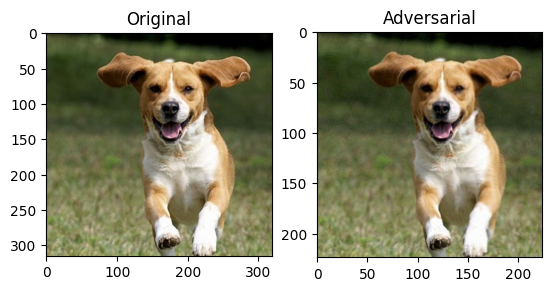

In [ ]:
#visualise the result
plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(img)

plt.subplot(1, 2, 2)
plt.title("Adversarial")
plt.imshow(transforms.ToPILImage()(perturbed_img.squeeze()))
plt.show()


In [ ]:
import json
import urllib.request

# Download ImageNet class labels
url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
imagenet_classes = urllib.request.urlopen(url).read().decode("utf-8").splitlines()


In [ ]:
# Assuming you already have model predictions:
original_pred_idx = 208   # example
adv_pred_idx = 180        # example

# Get class names
original_label = imagenet_classes[original_pred_idx]
adv_label = imagenet_classes[adv_pred_idx]

print("Original Prediction:", original_label)
print("Adversarial Prediction:", adv_label)


Original Prediction: Labrador retriever
Adversarial Prediction: American Staffordshire terrier


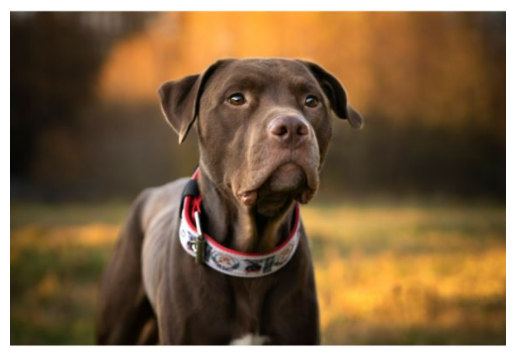

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# Replace 'your_image.jpg' with your actual image filename
img_path = 'dog2.jpg'

# Open the image
img = Image.open(img_path)

# Display the image
plt.imshow(img)
plt.axis('off')  # Hide axis
plt.show()
